# Is income to loan ratio a major factor to determine risk factor?
We will answer this question by using a machine learning algorith to predict if there is a connection between income to loan ratio

In [1]:
#first we will import our inline matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import psycopg2

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
import time

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lampi\anaconda3\envs\Pythondata\lib\site-packages

# we are now going to connect our postgress DB into out jupyter notebook using SQLalchemy

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

### DELETE THE NEXT CELL BECAUSE IT HOLDS SENSITIVE INFORMATION ABOUT POSTGRESS. 
CREATE A config.py FILE AND IMPORT USING THE COMMANDS BELOW

ADD config.py TO gitignore

In [4]:
from config import POSTGRES_ADDRESS
from config import POSTGRES_PORT
from config import POSTGRES_USERNAME
from config import POSTGRES_PASSWORD
from config import POSTGRES_DBNAME

### Lets Crete our engine to link postgress to our jupyter file. This will allow us to access the dataset we have uploaded.

In [5]:
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname=POSTGRES_DBNAME))
# Create the connection
engine = create_engine(postgres_str)

In [6]:
merged_db= pd.read_sql_query('''SELECT * FROM merged;''', engine)
merged_db

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297447,999977469387,C,PENNYMAC CORP.,5,250000,360,2018-12-01,2019-02-01,80,80,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297448,999978067692,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",5,123000,360,2018-12-01,2019-02-01,95,95,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297449,999983023544,R,OTHER,5,280000,240,2018-12-01,2019-02-01,69,69,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None
297450,999984004377,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,155000,360,2019-01-01,2019-03-01,97,97,...,None,NaN,NaN,NaN,NaN,None,NaN,None,None,None


### Description Of The Source Of Data

Fannie Mae provides loan performance data on a portion of its single-family mortgage loans to promote better understanding of the credit performance of Fannie Mae mortgage loans.

Link: https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html

In [7]:
# Import our input dataset
#mortgage_df = pd.read_csv('Final Project Data.csv')
mortgage_df = merged_db
mortgage_df.head()

,loan_identifier,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,...,monthly_reporting_period,current_interest_rate,loan_age,remaining_months_to_legal_maturity,adj_remaining_months_to_maturity,maturity_date,msa,current_loan_delinquency_status,modification_flag,delinquency
0,100000913397,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,...,2019-12-01,5.88,14.0,346.0,346.0,2048-10-01,40140.0,0,N,False
1,100017539727,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,...,2019-12-01,4.75,11.0,349.0,349.0,2049-01-01,26420.0,0,N,False
2,100018053040,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,...,2019-12-01,4.88,12.0,348.0,348.0,2048-12-01,0.0,0,N,False
3,100019764317,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,...,2019-10-01,4.88,9.0,351.0,0.0,2049-01-01,16980.0,X,N,True
4,100019765730,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,...,2019-12-01,4.25,8.0,352.0,352.0,2049-04-01,41860.0,0,N,False


In [8]:
len(mortgage_df.index)

297452

In [9]:
mortgage_df.isnull().sum()

loan_identifier                              0
origination_channel                          0
seller_name                                  0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
property_type                                0
number_of_units                              0
occupancy_type                               0
property_state                               0
zip_code_short                               0
primary_mortgage_insurance_percent      185901
product_type 

### Drop Cloumns with low value to our model or high NULL values

In [10]:
# Drop the unwanted variables from the data
mortgage_input = mortgage_df.drop(columns = ['loan_identifier', 
'maturity_date',
'monthly_reporting_period',
'current_interest_rate',
'loan_age',
'remaining_months_to_legal_maturity',
'adj_remaining_months_to_maturity',
'maturity_date',
'primary_mortgage_insurance_percent',
'current_loan_delinquency_status',
'modification_flag' ])
mortgage_input.head()

,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,...,loan_purpose,property_type,number_of_units,occupancy_type,property_state,zip_code_short,product_type,relocation_mortgage_indicator,msa,delinquency
0,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,2,...,C,PU,1,P,CA,925,FRM,N,40140.0,False
1,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,1,...,P,PU,1,P,TX,770,FRM,N,26420.0,False
2,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,2,...,P,SF,1,S,NC,286,FRM,N,0.0,False
3,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,2,...,P,SF,1,P,IL,600,FRM,N,16980.0,True
4,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,1,...,P,CO,1,P,CA,945,FRM,N,41860.0,False


In [11]:
mortgage_input.isnull().sum()

origination_channel                          0
seller_name                                  0
original_interest_rate                       0
original_upb                                 0
original_loan_term                           0
origination_date                             0
first_payment_date                           0
original_ltv                                 0
original_cltv                                0
number_of_borrowers                          0
original_dir                                96
borrower_credit_score_at_origination       385
first_time_home_buyer_indicator              0
loan_purpose                                 0
property_type                                0
number_of_units                              0
occupancy_type                               0
property_state                               0
zip_code_short                               0
product_type                                 0
relocation_mortgage_indicator                0
msa          

### Remove all Nan Values

In [12]:
# Drop NA rows
mortgage_input = mortgage_input.dropna()
len(mortgage_input.index)
mortgage_input.head(10)

,origination_channel,seller_name,original_interest_rate,original_upb,original_loan_term,origination_date,first_payment_date,original_ltv,original_cltv,number_of_borrowers,...,loan_purpose,property_type,number_of_units,occupancy_type,property_state,zip_code_short,product_type,relocation_mortgage_indicator,msa,delinquency
0,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6,324000,360,2018-09-01,2018-11-01,80,80,2,...,C,PU,1,P,CA,925,FRM,N,40140.0,False
1,B,OTHER,5,307000,360,2018-12-01,2019-02-01,90,90,1,...,P,PU,1,P,TX,770,FRM,N,26420.0,False
2,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,256000,360,2018-11-01,2019-01-01,90,90,2,...,P,SF,1,S,NC,286,FRM,N,0.0,False
3,C,"WELLS FARGO BANK, N.A.",5,248000,360,2018-12-01,2019-02-01,90,90,2,...,P,SF,1,P,IL,600,FRM,N,16980.0,True
4,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",4,490000,360,2019-03-01,2019-05-01,67,67,1,...,P,CO,1,P,CA,945,FRM,N,41860.0,False
5,C,"WELLS FARGO BANK, N.A.",5,453000,360,2018-12-01,2019-02-01,69,69,2,...,P,PU,1,P,FL,337,FRM,N,45300.0,False
6,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",5,264000,360,2018-10-01,2018-12-01,95,95,2,...,P,PU,1,P,TX,773,FRM,Y,26420.0,False
7,R,"MOVEMENT MORTGAGE, LLC",5,426000,360,2019-01-01,2019-03-01,80,80,1,...,P,CO,1,P,TX,752,FRM,N,19100.0,False
8,R,OTHER,5,174000,360,2018-12-01,2019-02-01,97,97,2,...,P,SF,1,P,IN,479,FRM,N,0.0,False
9,B,"UNITED SHORE FINANCIAL SERVICES, LLC DBA UNITE...",5,204000,360,2019-01-01,2019-03-01,95,95,2,...,P,PU,1,P,UT,844,FRM,N,36260.0,False


### Now that we have cleaned our data set, lets see what input we have for our ML model

In [13]:
# Generate our categorical variable list
mortgage_cat = mortgage_input.dtypes[mortgage_input.dtypes == "object"].index.tolist()
mortgage_cat

['origination_channel',
 'seller_name',
 'origination_date',
 'first_payment_date',
 'first_time_home_buyer_indicator',
 'loan_purpose',
 'property_type',
 'occupancy_type',
 'property_state',
 'product_type',
 'relocation_mortgage_indicator',
 'delinquency']

### Since we are focusing on potential forclosure risk, we will be looking in to all the states, all the loan sellers, type of property and other indicators

In [14]:
# Check the number of unique values in each column
mortgage_input[mortgage_cat].nunique()

origination_channel                 3
seller_name                        17
origination_date                   26
first_payment_date                 26
first_time_home_buyer_indicator     2
loan_purpose                        3
property_type                       5
occupancy_type                      3
property_state                     54
product_type                        1
relocation_mortgage_indicator       2
delinquency                         2
dtype: int64

### we will now use one hot encoder to turn object/string data into interbased data to set up our ML

In [15]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(mortgage_input[mortgage_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(mortgage_cat)
encode_df.head()

,origination_channel_B,origination_channel_C,origination_channel_R,"seller_name_AMERIHOME MORTGAGE COMPANY, LLC",seller_name_DITECH FINANCIAL LLC,"seller_name_EAGLE HOME MORTGAGE, LLC",seller_name_FAIRWAY INDEPENDENT MORTGAGE CORPORATION,"seller_name_FLAGSTAR BANK, FSB",seller_name_FREEDOM MORTGAGE CORP.,"seller_name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",...,property_state_VT,property_state_WA,property_state_WI,property_state_WV,property_state_WY,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### We will now merge the one hot encoder data to our original dataset

In [16]:
# Merge one-hot encoded features and drop the originals
mortgage_merged = mortgage_input.merge(encode_df,left_index=True, right_index=True)
mortgage_merged = mortgage_merged.drop(mortgage_cat,1)
mortgage_merged.head()

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,zip_code_short,...,property_state_VT,property_state_WA,property_state_WI,property_state_WV,property_state_WY,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
0,6,324000,360,80,80,2,49.0,692.0,1,925,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,5,307000,360,90,90,1,44.0,722.0,1,770,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,5,256000,360,90,90,2,41.0,728.0,1,286,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,5,248000,360,90,90,2,40.0,730.0,1,600,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,4,490000,360,67,67,1,35.0,727.0,1,945,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [17]:
mortgage_merged.tail()

,original_interest_rate,original_upb,original_loan_term,original_ltv,original_cltv,number_of_borrowers,original_dir,borrower_credit_score_at_origination,number_of_units,zip_code_short,...,property_state_VT,property_state_WA,property_state_WI,property_state_WV,property_state_WY,product_type_FRM,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,delinquency_False,delinquency_True
100286,5,279000,360,95,95,2,28.0,791.0,1,840,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
100287,6,170000,360,97,101,1,30.0,768.0,1,806,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
100288,5,216000,360,40,40,2,31.0,770.0,1,686,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
100289,5,188000,360,95,95,1,43.0,726.0,1,827,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
100290,4,140000,180,70,70,2,22.0,805.0,1,441,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [18]:
# Split our preprocessed data into our features and target arrays
y = mortgage_merged["delinquency_True"].values
X = mortgage_merged.drop(["delinquency_True", "delinquency_False"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# For logical regression use the next few cells

### Model the Data Results Logical Regression


### Lets fit the model and evaluate the results

## FOR DEEP FOREST MODELING USE THE FOLLOWING CELLS

In [20]:
#% For deep forest neural network use this cell and all cells with % sign
from sklearn.metrics import accuracy_score

# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.786


## We have added multiple layers to better train our model with varying node sizes.
### for testing the code epoch is set to <10
### for performance and evaluation, change epoch to >60

In [21]:
#% For deep forest neural network use this cell and all cells with % sign

# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

#add multiple hidden layers
#first i created a list of int to be used as nodes, add more digits to be used as i in our range value in the next line
units = [ 32, 21, 15, 6, 11, 17, 5]

#then using a for loop i created multiple layers for our machine learning model
for i in range( 7 ):
    nn.add( tf.keras.layers.Dense( units[i] , activation= "tanh" ) )

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model (play around with the epoch number, curve starts to flatten after 70 epochs)
fit_model = nn.fit(X_train_scaled, y_train, epochs=1)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
74838/74838 [==============================] - 7s 99us/sample - loss: 0.4978 - acc: 0.7845
24947/24947 - 1s - loss: 0.4879 - acc: 0.7868
Loss: 0.487875601750947, Accuracy: 0.7867879867553711


### Deep Forest Result
##### We received 76% accuracy and just over 51% loss. There is some tweaking needed here, will have to return to this

## LETS TAKE A LOOK AT HOW OUR MODEL PERFORMED

Text(0.5, 0, 'epoch')

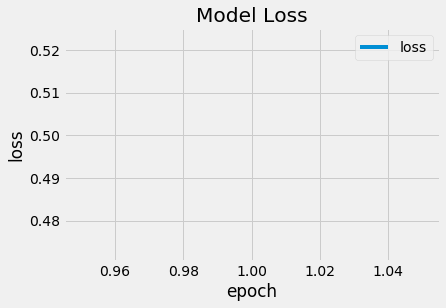

In [22]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

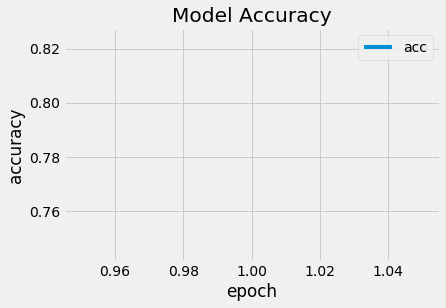

In [23]:
# Plot the accuracy
history_df.plot(y="acc")
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [24]:
X_train_scaled

array([[ 1.77725897,  0.58016294,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-0.09015425,  0.72986183,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-1.95756748, -1.0665249 , -2.9732483 , ...,  0.        ,
         0.07734175, -0.07734175],
       ...,
       [-0.09015425, -0.79864267,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-0.09015425,  1.95896854,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175],
       [-1.95756748, -0.08166375,  0.34276339, ...,  0.        ,
         0.07734175, -0.07734175]])

# Next we will focus on state vs state and see if there are some who perform better than other.

In [54]:
state_results = merged_db[['property_state','delinquency']]

In [55]:
state_results= state_results.dropna()

In [56]:
state_results.delinquency.value_counts(normalize=True)

False    0.785571
True     0.214429
Name: delinquency, dtype: float64

### We will turn our data into a DF

In [124]:
state_vs = state_results.delinquency.groupby(state_results['property_state']).value_counts()

In [125]:
state_vs

property_state  delinquency
AK              False           119
                True             17
AL              False           928
                True            185
AR              False           500
                True             80
AZ              False          2981
                True           1070
CA              False          8751
                True           4175
CO              False          2440
                True           1110
CT              False           750
                True            127
DC              False           190
                True             62
DE              False           298
                True             80
FL              False          7131
                True           1108
GA              False          2750
                True            549
GU              False             2
HI              False           304
                True             85
IA              False           651
                True            175


In [126]:
statevs_df = pd.DataFrame(state_vs)
statevs_df

delinquency
property_state delinquency             
AK             False                119
               True                  17
AL             False                928
               True                 185
AR             False                500
               True                  80
AZ             False               2981
               True                1070
CA             False               8751
               True                4175
CO             False               2440
               True                1110
CT             False                750
               True                 127
DC             False                190
               True                  62
DE             False                298
               True                  80
FL             False               7131
               True                1108
GA             False               2750
               True                 549
GU             False                  2
HI             False                304
               True                  85
IA             False                651
               True                 175
ID             False                739
               True                 239
IL             False               2442
               True                 816
IN             False               1353
               True                 330
KS             False                432
               True                 113
KY             False                626
               True                 189
LA             False                774
               True                 159
MA             False               1384
               True                 608
MD             False               1413
               True                 416
ME             False                200
               True                  52
MI             False               2432
               True                 718
MN             False               1674
               True                 462
MO             False               1356
               True                 423
MS             False                387
               True                  83
MT             False                318
               True                  74
NC             False               2680
               True                 598
ND             False                106
               True                  24
NE             False                534
               True                 143
NH             False                326
               True                 111
NJ             False               1956
               True                 560
NM             False                500
               True                  70
NV             False               1550
               True                 416
NY             False               2684
               True                 378
OH             False               2302
               True                 406
OK             False                642
               True                  85
OR             False               1333
               True                 397
PA             False               2304
               True                 516
PR             False                145
               True                   6
RI             False                253
               True                  63
SC             False               1435
               True                 298
SD             False                193
               True                  60
TN             False               1670
               True                 349
TX             False               7340
               True                1060
UT             False               1283
               True                 605
VA             False               1887
               True                 504
VI             False                  8
               True                   2
VT             False                132
               True         

### Lets change the boolean values into percentage by using a lambda function

In [127]:
state_pcts = statevs_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
pd.set_option('display.max_rows', None)
state_pcts

delinquency
property_state delinquency             
AK             False          87.500000
               True           12.500000
AL             False          83.378257
               True           16.621743
AR             False          86.206897
               True           13.793103
AZ             False          73.586769
               True           26.413231
CA             False          67.700758
               True           32.299242
CO             False          68.732394
               True           31.267606
CT             False          85.518814
               True           14.481186
DC             False          75.396825
               True           24.603175
DE             False          78.835979
               True           21.164021
FL             False          86.551766
               True           13.448234
GA             False          83.358594
               True           16.641406
GU             False         100.000000
HI             False          78.149100
               True           21.850900
IA             False          78.813559
               True           21.186441
ID             False          75.562372
               True           24.437628
IL             False          74.953959
               True           25.046041
IN             False          80.392157
               True           19.607843
KS             False          79.266055
               True           20.733945
KY             False          76.809816
               True           23.190184
LA             False          82.958199
               True           17.041801
MA             False          69.477912
               True           30.522088
MD             False          77.255331
               True           22.744669
ME             False          79.365079
               True           20.634921
MI             False          77.206349
               True           22.793651
MN             False          78.370787
               True           21.629213
MO             False          76.222597
               True           23.777403
MS             False          82.340426
               True           17.659574
MT             False          81.122449
               True           18.877551
NC             False          81.757169
               True           18.242831
ND             False          81.538462
               True           18.461538
NE             False          78.877400
               True           21.122600
NH             False          74.599542
               True           25.400458
NJ             False          77.742448
               True           22.257552
NM             False          87.719298
               True           12.280702
NV             False          78.840285
               True           21.159715
NY             False          87.655127
               True           12.344873
OH             False          85.007386
               True           14.992614
OK             False          88.308116
               True           11.691884
OR             False          77.052023
               True           22.947977
PA             False          81.702128
               True           18.297872
PR             False          96.026490
               True            3.973510
RI             False          80.063291
               True           19.936709
SC             False          82.804385
               True           17.195615
SD             False          76.284585
               True           23.715415
TN             False          82.714215
               True           17.285785
TX             False          87.380952
               True           12.619048
UT             False          67.955508
               True           32.044492
VA             False          78.920954
               True           21.079046
VI             False          80.000000
               True           20.000000
VT             False          89.189189
               True         

### There are two columns with same name, so lets change that

In [122]:
state_pcts.rename(columns={'delinquency' : 'Percentage'}, inplace=True)
state_pcts